In [1]:
import quarters
import companies
import numpy as np
import pandas as pd
import numpy.linalg as la
import datetime
import yfinance as yf
import warnings

warnings.simplefilter("ignore")

start_year = 1995
end_year = 2019
a = np.array([0.023734,1.329796395805503/100])

In [2]:
def get_stock_weights(start_year, end_year, a):
    rfr = quarters.get_mean_rfr_between_years(start_year, end_year)
    gdp = quarters.get_gdp_growth_between_years(start_year, end_year)

    returns = pd.read_csv(f'./data/returns/returns_{start_year}-{end_year}.csv').set_index('Unnamed: 0')

    mu1 = returns.mean()
    mu2 = np.array([np.mean(rfr), np.mean(gdp)])
    #print(mu2)
    all_companies = returns.columns
    n_companies = returns.shape[1]

    #adding external parameters
    returns['avg_rfr'] = rfr
    returns['gdp_growth'] = gdp

    total_points = returns.shape[1]
    
    returns_array = returns.to_numpy().T.astype(float)
    cov_array = np.cov(returns_array)
    #print(cov_array)
    sigma11 = cov_array[0:n_companies, 0:n_companies]
    sigma21 = cov_array[n_companies:total_points, 0:n_companies]
    sigma12 = cov_array[0:n_companies, n_companies:total_points]
    sigma22 = cov_array[n_companies:total_points, n_companies:total_points]
    #print(sigma12, sigma22)
    mu = mu1 + sigma12@la.inv(sigma22)@(a-mu2)
    sigma = sigma11 - sigma12@la.inv(sigma22)@sigma21
    w_prime_cond = la.inv(sigma)@mu/(np.ones(n_companies)@la.inv(sigma)@mu)
    w_prime = la.inv(sigma11)@mu1/(np.ones(n_companies)@la.inv(sigma11)@mu1)
    return w_prime_cond, w_prime

In [3]:
from compare import compare_to_benchmark

Q1 2019
                           benchmark  portfolio_1
Date                                             
2019-01-02 00:00:00-05:00   1.000000     1.000000
2019-01-03 00:00:00-05:00   0.976137     0.991257
2019-01-04 00:00:00-05:00   1.008834     1.013335
2019-01-07 00:00:00-05:00   1.016788     1.017822
2019-01-08 00:00:00-05:00   1.026341     1.033049
...                              ...          ...
2019-03-27 00:00:00-04:00   1.122719     1.104729
2019-03-28 00:00:00-04:00   1.126974     1.102315
2019-03-29 00:00:00-04:00   1.134080     1.109216
2019-04-01 00:00:00-04:00   1.147529     1.118040
2019-04-02 00:00:00-04:00   1.148092     1.119534

[63 rows x 2 columns]
Q2 2019
                           benchmark  portfolio_1
Date                                             
2019-04-02 00:00:00-04:00   1.148092     1.119534
2019-04-03 00:00:00-04:00   1.149898     1.121508
2019-04-04 00:00:00-04:00   1.152950     1.123299
2019-04-05 00:00:00-04:00   1.158530     1.129992
2019-04-08 

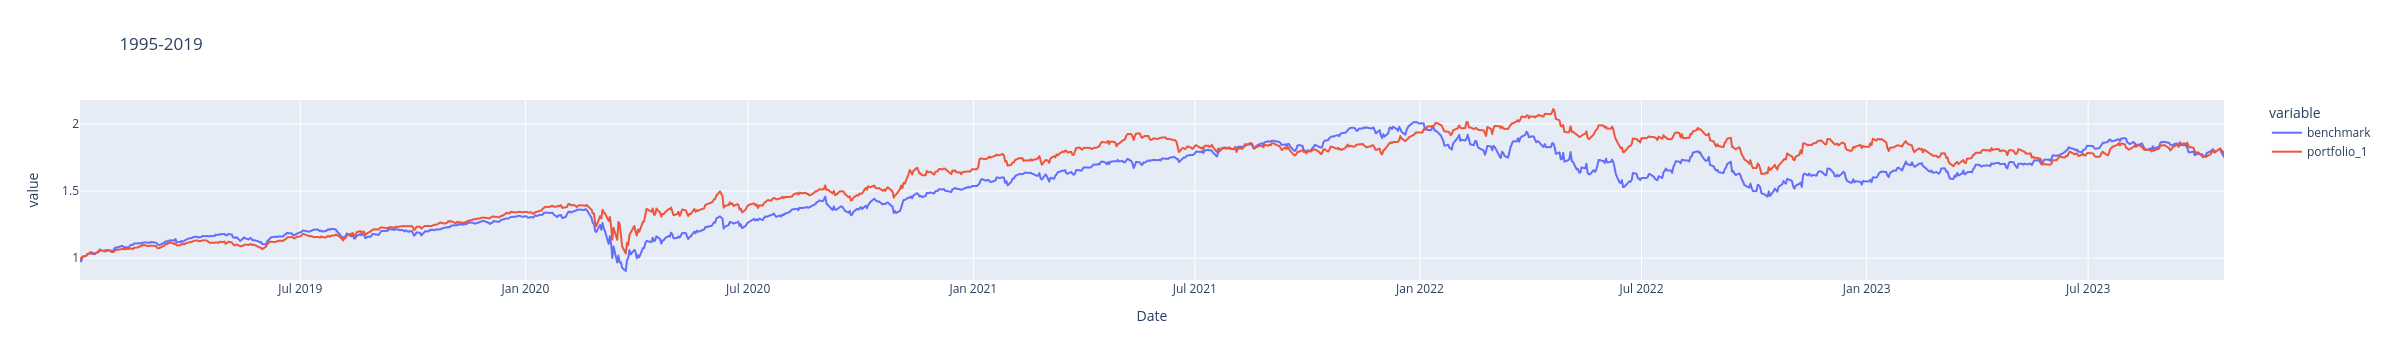

In [13]:
import json
import companies
import os
import plotly.express as px

start_year_val = 1995
end_year_val = 2019

all_companies = pd.read_csv(f'./data/returns/returns_{split}.csv').set_index('Unnamed: 0').columns

q_dates = quarters.get_dates_between_years(2019, 2024)

df = pd.DataFrame(columns=['benchmark'])
for year in q_dates:
    for quarter in q_dates[year]:
        print(quarter, year)
        weights = json.load(open(os.path.join('./weights', '1995-2019-full.json'), 'r'))[str(year)][quarter]['weights']
        
        start_date = q_dates[year][quarter]['start']
        end_date = q_dates[year][quarter]['end']

        filtered = [weight if weight > 0.001 else 0 for weight in weights]
        filtered /= np.array(filtered).sum()
        
        comparison = compare_to_benchmark([filtered], all_companies, start_date)
        range = comparison.loc[(comparison.index>=start_date-datetime.timedelta(days=2)) & (comparison.index<=end_date+datetime.timedelta(days=2))]
        if df.empty:
            df = range
        else:
            last_row = df.iloc[-1]

            for column in last_row.index:
                value = last_row[column]
                range[column] *= value
            
            df = pd.concat([df, range])
        print(range)
plot = px.line(df, title=split)
plot.show()
df.to_csv(f'./benchmarks/2019-present-rfr-only.csv')

In [6]:
import json
import companies
import os
import plotly.express as px

start_year_val = 1995
end_year_val = 2019

#all_companies = companies.get_all_returns_between_years(start_year_val, end_year_val)

q_dates = quarters.get_dates_between_years(end_year_val, 2023)

for weight_file in os.listdir('./weights'):
    print(weight_file)
    split = weight_file.split(".")[0]
    all_companies = pd.read_csv(f'./data/returns/returns_{split}.csv').set_index('Unnamed: 0').columns
    print(all_companies)
    df = pd.DataFrame(columns=['benchmark'])
    print(split)
    for year in q_dates:
        for quarter in q_dates[year]:
            
            weights = json.load(open(os.path.join('./weights', weight_file), 'r'))[str(year)][quarter]['weights']
            
            start_date = q_dates[year][quarter]['start']
            end_date = q_dates[year][quarter]['end']

            filtered = [weight if weight > 0.001 else 0 for weight in weights]
            filtered /= np.array(filtered).sum()
            
            comparison = compare_to_benchmark([filtered], all_companies, start_date)
            range = comparison.loc[(comparison.index>=start_date-datetime.timedelta(days=2)) & (comparison.index<=end_date+datetime.timedelta(days=2))]
            if df.empty:
                df = range
            else:
                last_row = df.iloc[-1]
    
                for column in last_row.index:
                    value = last_row[column]
                    range[column] *= value
                
                df = pd.concat([df, range])
    plot = px.line(df, title=split)
    plot.show()
    df.to_csv(f'./benchmarks/{split}-filtered.csv')

1995-2019.json
Index(['MMM', 'ABT', 'ADM', 'ADP', 'APD', 'MO', 'AEP', 'AXP', 'AIG', 'AMGN',
       ...
       'UNP', 'UNH', 'VZ', 'VFC', 'WBA', 'WMT', 'WFC', 'WMB', 'GWW', 'XEL'],
      dtype='object', length=134)
1995-2019


KeyboardInterrupt: 

In [ ]:
import plotly.express as px
#comparison['benchmark']  = comparison
comparison2010 = df
px.line(comparison2010)